# Prediction by category 

## 1 Overview

 - We use a SARIMA model to forecast the monthly sells at November 2015 based on data grouped by item category.
 
 - We suppose that missing information means no sells.

## 2 Initial setup

In [1]:
# Load packages.
import sys
import datetime
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

import warnings

# Ignore warning messages
warnings.filterwarnings("ignore")
    
%matplotlib inline

In [2]:
print("Python", sys.version)
print("Pandas:", pd.__version__)

Python 3.6.7 | packaged by conda-forge | (default, Nov 21 2018, 02:32:25) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas: 0.23.4


## 2 Load and pre-process data

### 2.1 Understanding data structure

In [3]:
# Where the data live.
FOLDER = "/home/alex/Desktop/competitive-data-science-predict-future-sales/"

In [4]:
# Load to pandas DataFrame objects.
ITEM_CATEGORIES = pd.read_csv(FOLDER + "item_categories.csv")
ITEMS = pd.read_csv(FOLDER + "items.csv")
SALES_TRAIN = pd.read_csv(FOLDER + "sales_train.csv")
SHOPS = pd.read_csv(FOLDER + "shops.csv")
TEST = pd.read_csv(FOLDER + "test.csv")

In [5]:
ITEM_CATEGORIES.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [6]:
ITEM_CATEGORIES.shape

(84, 2)

In [7]:
ITEMS.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [8]:
ITEMS.shape

(22170, 3)

In [9]:
SALES_TRAIN.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [10]:
SALES_TRAIN.shape

(2935849, 6)

In [11]:
SHOPS.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [12]:
SHOPS.shape

(60, 2)

In [13]:
TEST.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [14]:
TEST.shape

(214200, 3)

### 2.2 Pre-process and merge data

In [15]:
%%time

# Dates from strings to datetimes. It may take some time.
SALES_TRAIN.date = SALES_TRAIN.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

CPU times: user 46.4 s, sys: 113 ms, total: 46.5 s
Wall time: 46.7 s


In [16]:
# Add item name and category into train data set.
DATASET = pd.merge(SALES_TRAIN, ITEMS, how="left", on="item_id")

# Now we add the ID from the test set.
DATASET = pd.merge(DATASET, TEST, how="left")

# Add item category name.
DATASET = pd.merge(DATASET, ITEM_CATEGORIES, how="left")

# Re-order columns.
new_order = ["date", "date_block_num", "ID", "shop_id", "item_id", "item_name",
             "item_price", "item_cnt_day", "item_category_id", "item_category_name"]
DATASET = DATASET[new_order]

# Rename "date_block_num" column to "dn".
DATASET = DATASET.rename(columns={"date_block_num": "dn"})

# Let's see it.
DATASET.head(10)

date  dn        ID  shop_id  item_id  \
0 2013-01-02   0  150983.0       59    22154   
1 2013-01-03   0       NaN       25     2552   
2 2013-01-05   0       NaN       25     2552   
3 2013-01-06   0       NaN       25     2554   
4 2013-01-15   0       NaN       25     2555   
5 2013-01-10   0       NaN       25     2564   
6 2013-01-02   0       NaN       25     2565   
7 2013-01-04   0       NaN       25     2572   
8 2013-01-11   0       NaN       25     2572   
9 2013-01-03   0       NaN       25     2573   

                                           item_name  item_price  \
0                                  ЯВЛЕНИЕ 2012 (BD)      999.00   
1           DEEP PURPLE  The House Of Blue Light  LP      899.00   
2           DEEP PURPLE  The House Of Blue Light  LP      899.00   
3           DEEP PURPLE  Who Do You Think We Are  LP     1709.05   
4            DEEP PURPLE 30 Very Best Of 2CD (Фирм.)     1099.00   
5  DEEP PURPLE Perihelion: Live In Concert DVD (К...      349.00   
6                   DEEP PURPLE Stormbringer (фирм.)      549.00   
7                             DEFTONES  Koi No Yokan      239.00   
8                             DEFTONES  Koi No Yokan      299.00   
9                          DEL REY LANA  Born To Die      299.00   

   item_cnt_day  item_category_id                   item_category_name  
0           1.0                37                       Кино - Blu-Ray  
1           1.0                58                       Музыка - Винил  
2          -1.0                58                       Музыка - Винил  
3           1.0                58                       Музыка - Винил  
4           1.0                56  Музыка - CD фирменного производства  
5           1.0                59           Музыка - Музыкальное видео  
6           1.0                56  Музыка - CD фирменного производства  
7           1.0                55  Музыка - CD локального производства  
8           1.0                55  Музыка - CD локального производства  
9           3.0                55  Музыка - CD локального производства

In [17]:
DATASET.shape

(2935849, 10)

## 3 Explore and visualize

### 3.1 Important information

In [18]:
# Train.
items_train = len(DATASET.item_id.unique())
items_categories_train = len(DATASET.item_category_id.unique())
shops_train = len(DATASET.shop_id.unique())

# Test.
items_test = len(TEST.item_id.unique())
shops_test = len(TEST.shop_id.unique())
IDs_test = len(TEST.ID.unique())

# Both.
items_both = len(set(DATASET.item_id).intersection(set(TEST.item_id)))
shops_both = len(set(DATASET.shop_id).intersection(set(TEST.shop_id)))
IDs_both = len(set(DATASET.ID.unique()).intersection(set(TEST.ID.unique())))

print(">>> Number of (training set):")
print(" * categories:", items_categories_train)
print(" * items:", items_train)
print(" * shops:", shops_train)

print("\n>>> Number of (test set):")
print(" * items:", items_test)
print(" * shops:", shops_test)
print(" * Combinations items-shops (IDS):", IDs_test)

print("\n>>> Number of (in both training and test):")
print(" * items:", items_both)
print(" * shops:", shops_both)
print(" * Combinations items-shops (IDS):", IDs_both)

print("\n>>> Predictive load: %u/%u = %.2f%%" %(IDs_both, IDs_test, IDs_both / IDs_test * 100))

>>> Number of (training set):
 * categories: 84
 * items: 21807
 * shops: 60

>>> Number of (test set):
 * items: 5100
 * shops: 42
 * Combinations items-shops (IDS): 214200

>>> Number of (in both training and test):
 * items: 4737
 * shops: 42
 * Combinations items-shops (IDS): 111404

>>> Predictive load: 111404/214200 = 52.01%


In [19]:
ts = DATASET.item_cnt_day.sum()
nm = len(SALES_TRAIN.date_block_num.unique())
npred = IDs_test
statistics = ts / nm / npred

print(">>> On train data set:")
print("    Number of sales / Number of months / Predictions to be made:", statistics)

>>> On train data set:
    Number of sales / Number of months / Predictions to be made: 0.5009345306750151


In [20]:
# Group data by item category.
gr = DATASET.groupby(["item_category_id"])

# Make a pandas DataFrame based on item category.
names = ["shops_sell", "unique_items", "price_mean", "price_std", "total_sell", "months_sell"]
DATASET_cat = pd.DataFrame(columns=names)
DATASET_cat["shops_sell"] = gr["shop_id"].apply(lambda x: len(x.unique()))
DATASET_cat["unique_items"] = gr["item_id"].apply(lambda x: len(x.unique()))
DATASET_cat["price_mean"] = gr["item_price"].mean()
DATASET_cat["price_std"] = gr["item_price"].std()
DATASET_cat["total_sell"] = gr["item_cnt_day"].sum()
DATASET_cat["months_sell"] = gr["dn"].apply(lambda x: len(x.unique()))
DATASET_cat["stat"] = (DATASET_cat["total_sell"] / 
                       DATASET_cat["months_sell"] / DATASET_cat["unique_items"])

DATASET_cat.head(10)

shops_sell  unique_items   price_mean    price_std  \
item_category_id                                                       
0                          3             3    87.800000    62.961258   
1                          2             2   215.500000    95.459415   
2                         54            75  2261.705152  1175.068988   
3                         57            33  2105.683642  1435.229478   
4                         51            15   554.696081   487.282737   
5                         53            29   865.307153   757.659297   
6                         56            40  1892.904292  1152.964485   
7                         50            23  2713.552295  2011.640668   
8                         44             9  1345.441896   694.784320   
9                          1            12   814.342848  1657.406305   

                  total_sell  months_sell        stat  
item_category_id                                       
0                        3.0            3    0.333333  
1                        2.0            2    0.500000  
2                    19597.0           34    7.685098  
3                    29807.0           34   26.565954  
4                     2407.0           31    5.176344  
5                     7413.0           34    7.518256  
6                    20472.0           34   15.052941  
7                     5358.0           14   16.639752  
8                    13699.0           11  138.373737  
9                    18118.0           34   44.406863

### 3.2 Some figures for data grouped by categories

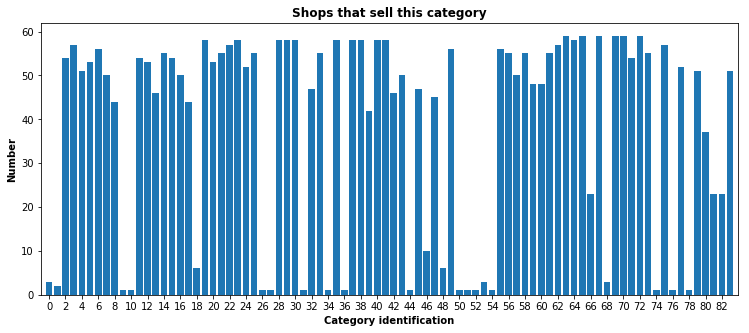

In [21]:
plt.figure(figsize=(12.5, 5))
plt.bar(DATASET_cat.index, DATASET_cat.shops_sell)
plt.xticks(range(0, 84, 2))
plt.xlim((-1, 84))
plt.xlabel("Category identification", weight="bold")
plt.ylabel("Number", weight="bold")
plt.title("Shops that sell this category", weight="bold");

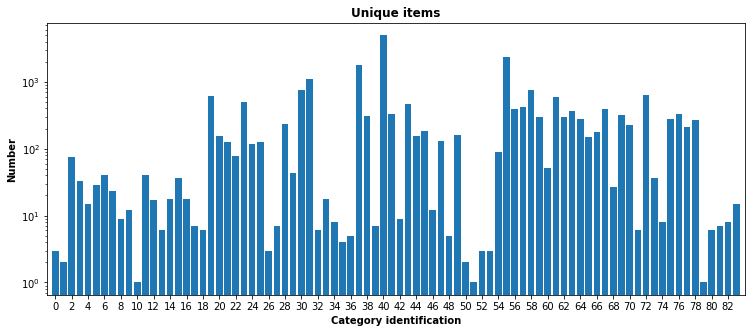

In [22]:
plt.figure(figsize=(12.5, 5))
plt.bar(DATASET_cat.index, DATASET_cat.unique_items)
plt.xticks(range(0, 84, 2))
plt.xlim((-1, 84))
plt.yscale("log")
plt.xlabel("Category identification", weight="bold")
plt.ylabel("Number", weight="bold")
plt.title("Unique items", weight="bold");

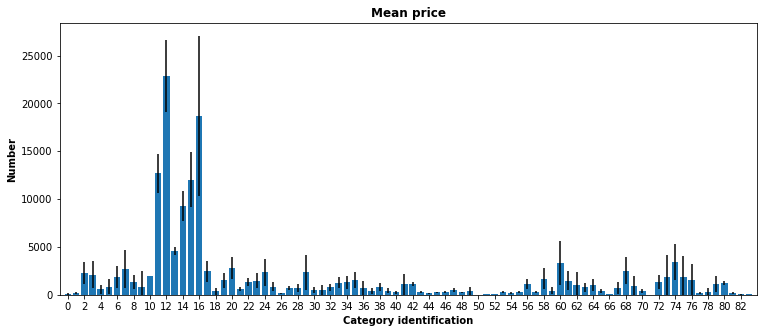

In [23]:
plt.figure(figsize=(12.5, 5))
plt.bar(DATASET_cat.index, DATASET_cat.price_mean, yerr=DATASET_cat.price_std)
plt.xticks(range(0, 84, 2))
plt.xlim((-1, 84))
plt.ylim((0, (DATASET_cat.price_mean + DATASET_cat.price_std).max() * 1.05))
plt.xlabel("Category identification", weight="bold")
plt.ylabel("Number", weight="bold")
plt.title("Mean price", weight="bold");

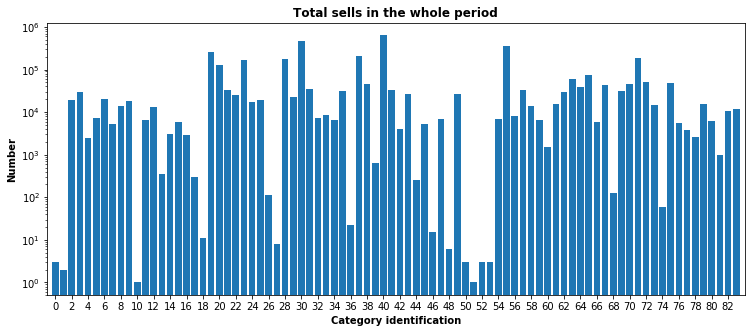

In [24]:
plt.figure(figsize=(12.5, 5))
plt.bar(DATASET_cat.index, DATASET_cat.total_sell)
plt.xticks(range(0, 84, 2))
plt.xlim((-1, 84))
plt.yscale("log")
plt.xlabel("Category identification", weight="bold")
plt.ylabel("Number", weight="bold")
plt.title("Total sells in the whole period", weight="bold");

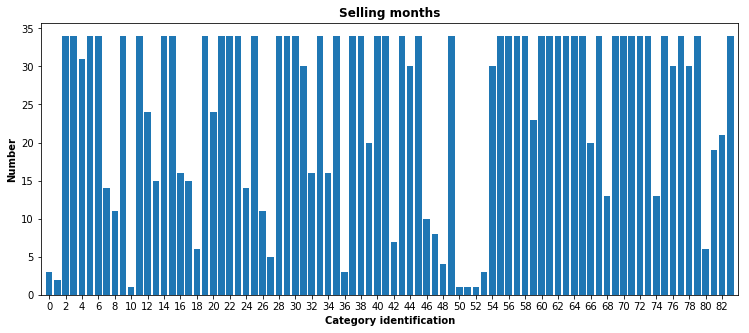

In [25]:
plt.figure(figsize=(12.5, 5))
plt.bar(DATASET_cat.index, DATASET_cat.months_sell)
plt.xticks(range(0, 84, 2))
plt.xlim((-1, 84))
plt.xlabel("Category identification", weight="bold")
plt.ylabel("Number", weight="bold")
plt.title("Selling months", weight="bold");

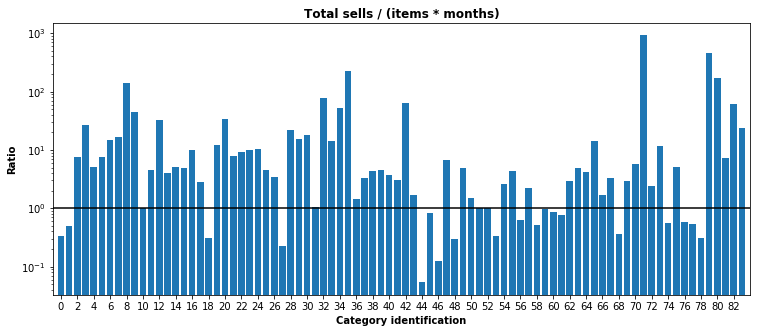

In [26]:
plt.figure(figsize=(12.5, 5))
plt.bar(DATASET_cat.index, DATASET_cat.stat)
plt.axhline(y=1, color="black")
plt.xticks(range(0, 84, 2))
plt.yscale("log")
plt.xlim((-1, 84))
plt.xlabel("Category identification", weight="bold")
plt.ylabel("Ratio", weight="bold")
plt.title("Total sells / (items * months)", weight="bold");

In [27]:
# New pandas DataFrame object with time series for each item category.
DATASET_p = DATASET.pivot_table(index="item_category_id", 
                                values="item_cnt_day", 
                                columns="dn",
                                aggfunc="sum")

DATASET_p.head(10)

dn                    0       1       2      3      4      5      6      7   \
item_category_id                                                              
0                    1.0     1.0     NaN    1.0    NaN    NaN    NaN    NaN   
1                    1.0     1.0     NaN    NaN    NaN    NaN    NaN    NaN   
2                 1390.0  1190.0  1025.0  646.0  596.0  667.0  618.0  674.0   
3                  440.0   302.0   293.0  202.0  146.0  150.0  233.0  300.0   
4                  251.0   220.0   226.0  160.0  175.0  176.0  179.0  140.0   
5                  623.0   358.0   354.0  275.0  281.0  329.0  355.0  299.0   
6                  870.0   668.0   646.0  465.0  441.0  502.0  622.0  637.0   
7                    NaN     NaN     NaN    NaN    NaN    NaN    NaN    NaN   
8                    NaN     NaN     NaN    NaN    NaN    NaN    NaN    NaN   
9                  149.0   159.0   211.0  138.0   95.0  124.0   83.0  124.0   

dn                   8       9    ...        24     25     26      27      28  \
item_category_id                  ...                                           
0                   NaN     NaN   ...       NaN    NaN    NaN     NaN     NaN   
1                   NaN     NaN   ...       NaN    NaN    NaN     NaN     NaN   
2                 792.0   790.0   ...     370.0  307.0  229.0   170.0   146.0   
3                 383.0   391.0   ...    1398.0  834.0  773.0   746.0   667.0   
4                  86.0    89.0   ...      10.0    2.0    2.0     2.0     2.0   
5                 289.0   257.0   ...     178.0   85.0   88.0    67.0    44.0   
6                 729.0  1016.0   ...     700.0  400.0  334.0   266.0   274.0   
7                   NaN     NaN   ...     639.0  220.0  269.0   244.0   217.0   
8                   NaN     NaN   ...       NaN    NaN    NaN    45.0   147.0   
9                 141.0   253.0   ...     467.0  480.0  492.0  1003.0  2005.0   

dn                   29     30     31      32      33  
item_category_id                                       
0                   NaN    NaN    NaN     NaN     NaN  
1                   NaN    NaN    NaN     NaN     NaN  
2                 104.0  114.0  132.0    89.0    82.0  
3                 559.0  603.0  975.0  1090.0  1059.0  
4                   1.0    NaN    1.0     NaN     NaN  
5                  51.0   48.0   45.0    31.0    44.0  
6                 319.0  243.0  277.0   237.0   242.0  
7                 238.0  178.0  307.0   244.0   205.0  
8                 117.0  193.0  483.0  5128.0    -1.0  
9                 528.0  513.0  276.0   816.0  2524.0  

[10 rows x 34 columns]

In [28]:
DATASET_p.shape

(84, 34)

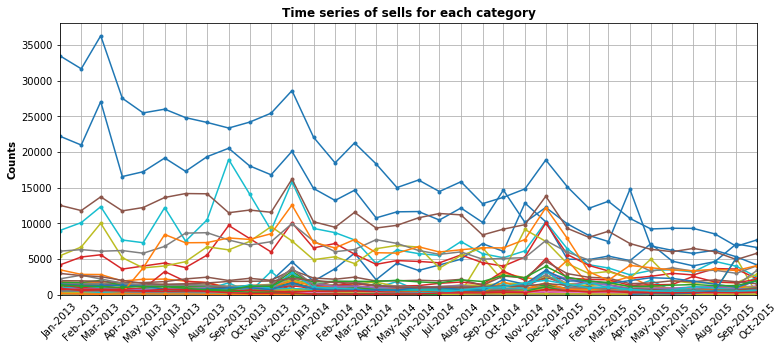

In [29]:
# Create figure.
plt.figure(figsize=(12.5, 5))

# For x axis.
timex = pd.date_range("2013-01", "2015-10", freq="MS")

# Plot one time series for each category.
for row in range(DATASET_p.shape[0]):
    plt.plot(timex, DATASET_p.iloc[row, :], ".-")

# More adjustments.
plt.xticks(timex)
plt.tick_params(axis="x", rotation=45)
plt.xlim((timex[0], timex[-1]))
plt.ylim((0, DATASET_p.dropna().max().max() * 1.05))
plt.ylabel("Counts", weight="bold")
plt.title("Time series of sells for each category", weight="bold")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
plt.grid();

## 4 Prediction using SARIMA

The SARIMA model, or **S**easonal **A**utoregressive **I**ntegrated **M**oving **A**verage, is a method for time series forecasting with univariate data containing trends and seasonality.

**Images taken from coursera's Practical Time Series Analysis.**

![SARIMA1](./figures/sarima1.png)

![SARIMA2](./figures/sarima2.png)

**References:**

 - [Practical Time Series Analysis](https://www.coursera.org/learn/practical-time-series-analysis) course in Coursera.

 - [A Gentle Introduction to SARIMA for Time Series Forecasting in Python](https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/).
 
 - [How to Grid Search SARIMA Model Hyperparameters for Time Series Forecasting in Python](https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/).
 
 - [A Gentle Introduction to Autocorrelation and Partial Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/).
 
 - [SARIMA implementation of statsmodels python package](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html).
 
 - [A Guide to Time Series Forecasting with ARIMA in Python 3](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3).

### 4.1 Auxiliary functions for SARIMA

In [30]:
################################################################################################
def make_grid(max_val=1):
    """
    Construct grid of hyper parameters for SARIMA. 
    """

    # Define the p, d and q parameters to take any value between 0 and max_val.
    p = d = q = range(0, max_val + 1)

    # Generate all different combinations of p, q and q triplets.
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal P, D and ! triplets.
    s = 12 # Annual cycle.
    PDQs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    
    return pdq, PDQs

################################################################################################
def grid_search(time_series, linear_params, seasonal_params, verbose=False):
    """
    Search for best choice for hyper parameters.
    """

    # Input parameters.
    ts = time_series
    pdq = linear_params
    PDQs = seasonal_params

    # Lists with results.
    pdqPDQs = []        # All hyper parameters.
    AIC = np.array([])  # Akaike Information Criterion.

    # Loop over grid.
    for param in pdq:
        for param_seasonal in PDQs:
            try:    
            
                # Instatiate model with the given hyper parameters.
                model = sm.tsa.statespace.SARIMAX(
                    ts,
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )

                # Results.
                results = model.fit()
                aic = results.aic

                if verbose:
                    print("* SARIMA{}x{}12 -> AIC:{}".format(param, param_seasonal, aic))

                pdqPDQs.append(param + param_seasonal)
                AIC = np.append(AIC, aic)
                
            except:
                continue
                
    # Best choice of hyper parameters.
    best = pdqPDQs[np.nanargmin(AIC)]
    non_seasonal = best[0: 3]
    seasonal = best[3: ]
    
    # Model for the best hyper parameters.
    model = sm.tsa.statespace.SARIMAX(
        ts,
        order=non_seasonal,
        seasonal_order=seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    # Information.
    results = model.fit()
    
    if verbose:
        print(results.summary())
    
    return results

################################################################################################
def plots(ts, results, cat):
    """
    Plots comparing predicted and observed time series.
    """
    
    # Predicted time series.
    tsp = results.predict(end="2015-11-01")

    # Make figure.
    plt.figure(figsize=(12, 4))
    plt.plot(ts.index, ts.values, ".-b", label="Observed")
    plt.plot(tsp.index, tsp.values, ".-r", label="Predicted")

    # More adjustments.
    plt.xticks(pd.date_range("2013-01-01", "2015-11-01", freq="MS"))
    plt.tick_params(axis="x", rotation=45)
    plt.xlim((pd.Timestamp("2013-01-01"), pd.Timestamp("2015-12-01")))
    plt.ylabel("Counts", weight="bold")
    plt.title("Time series of sells for category %d" %(cat), weight="bold")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
    plt.grid()
    plt.legend();

In [31]:
# Grid for searching best hyper parameters.
pdq, PDQs = make_grid()

# Columns as pandas DatetimeIndex object.
TS = DATASET_p.copy(deep=False)
TS.fillna(0, inplace=True)  # Suppose that missing information means no sells.
TS.columns = timex
TS.head()

2013-01-01  2013-02-01  2013-03-01  2013-04-01  2013-05-01  \
item_category_id                                                               
0                        1.0         1.0         0.0         1.0         0.0   
1                        1.0         1.0         0.0         0.0         0.0   
2                     1390.0      1190.0      1025.0       646.0       596.0   
3                      440.0       302.0       293.0       202.0       146.0   
4                      251.0       220.0       226.0       160.0       175.0   

                  2013-06-01  2013-07-01  2013-08-01  2013-09-01  2013-10-01  \
item_category_id                                                               
0                        0.0         0.0         0.0         0.0         0.0   
1                        0.0         0.0         0.0         0.0         0.0   
2                      667.0       618.0       674.0       792.0       790.0   
3                      150.0       233.0       300.0       383.0       391.0   
4                      176.0       179.0       140.0        86.0        89.0   

                     ...      2015-01-01  2015-02-01  2015-03-01  2015-04-01  \
item_category_id     ...                                                       
0                    ...             0.0         0.0         0.0         0.0   
1                    ...             0.0         0.0         0.0         0.0   
2                    ...           370.0       307.0       229.0       170.0   
3                    ...          1398.0       834.0       773.0       746.0   
4                    ...            10.0         2.0         2.0         2.0   

                  2015-05-01  2015-06-01  2015-07-01  2015-08-01  2015-09-01  \
item_category_id                                                               
0                        0.0         0.0         0.0         0.0         0.0   
1                        0.0         0.0         0.0         0.0         0.0   
2                      146.0       104.0       114.0       132.0        89.0   
3                      667.0       559.0       603.0       975.0      1090.0   
4                        2.0         1.0         0.0         1.0         0.0   

                  2015-10-01  
item_category_id              
0                        0.0  
1                        0.0  
2                       82.0  
3                     1059.0  
4                        0.0  

[5 rows x 34 columns]

In [32]:
# Just an fitting example in verbose mode.
cat = 0

ts = TS.iloc[cat, :]
results = grid_search(ts, pdq, PDQs, verbose=True)

* SARIMA(0, 0, 0)x(0, 0, 0, 12)12 -> AIC:3.1390506239220146
* SARIMA(0, 0, 0)x(0, 1, 0, 12)12 -> AIC:12.2165380053941
* SARIMA(0, 0, 1)x(0, 0, 0, 12)12 -> AIC:-16.091482723675647
* SARIMA(0, 0, 1)x(0, 1, 0, 12)12 -> AIC:0.8428958799414836
* SARIMA(0, 0, 1)x(1, 0, 0, 12)12 -> AIC:-493.0002276762895
* SARIMA(0, 0, 1)x(1, 1, 0, 12)12 -> AIC:-216.5933712597052
* SARIMA(0, 1, 0)x(0, 0, 0, 12)12 -> AIC:17.064110490036306
* SARIMA(0, 1, 0)x(0, 1, 0, 12)12 -> AIC:20.815141624946204
* SARIMA(0, 1, 0)x(1, 1, 0, 12)12 -> AIC:nan
* SARIMA(0, 1, 1)x(0, 0, 0, 12)12 -> AIC:-14.370094403056473
* SARIMA(0, 1, 1)x(0, 1, 0, 12)12 -> AIC:1.9936524749836617
* SARIMA(0, 1, 1)x(1, 0, 0, 12)12 -> AIC:-409.6771277928968
* SARIMA(0, 1, 1)x(1, 1, 0, 12)12 -> AIC:nan
* SARIMA(1, 0, 0)x(0, 0, 0, 12)12 -> AIC:-0.8775607526077698
* SARIMA(1, 0, 0)x(0, 1, 0, 12)12 -> AIC:10.387785270184802
* SARIMA(1, 0, 0)x(1, 0, 0, 12)12 -> AIC:-606.6167454153721
* SARIMA(1, 0, 0)x(1, 1, 0, 12)12 -> AIC:-185.62508704985595
* SARIMA

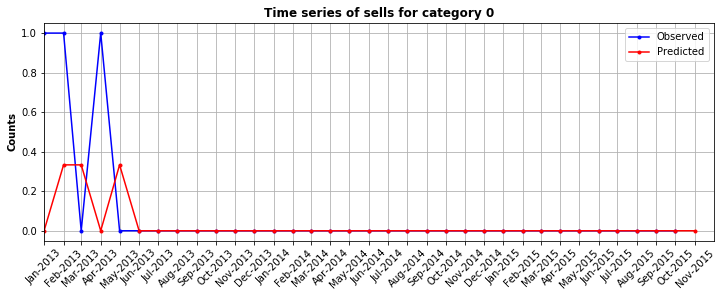

In [33]:
# Comparing predicted and observed time series.
plots(ts, results, cat)

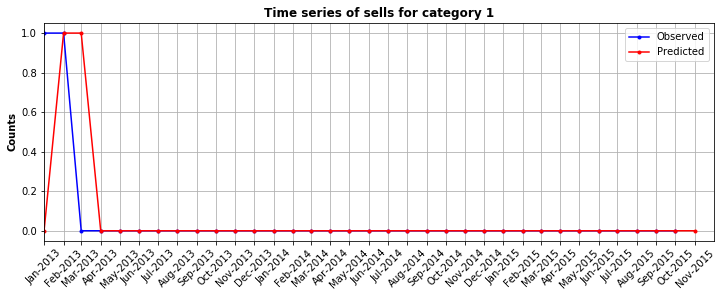

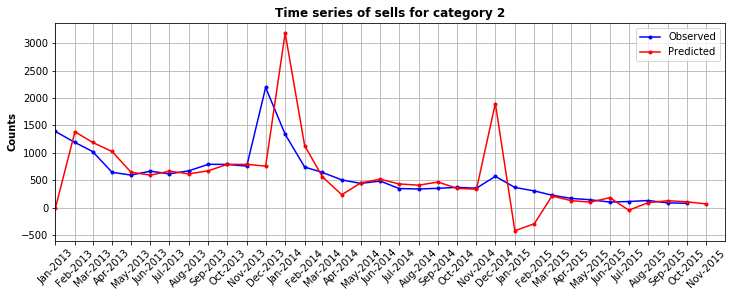

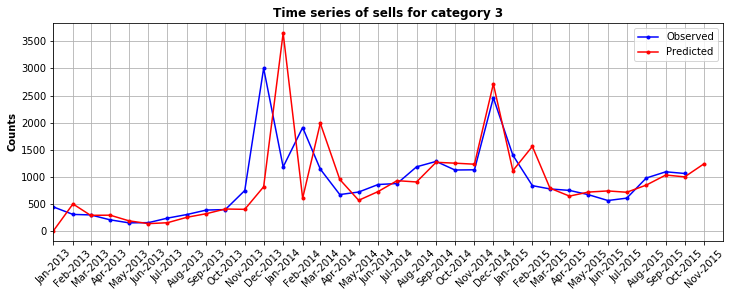

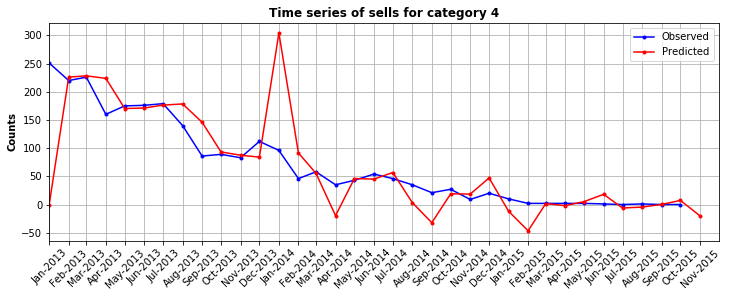

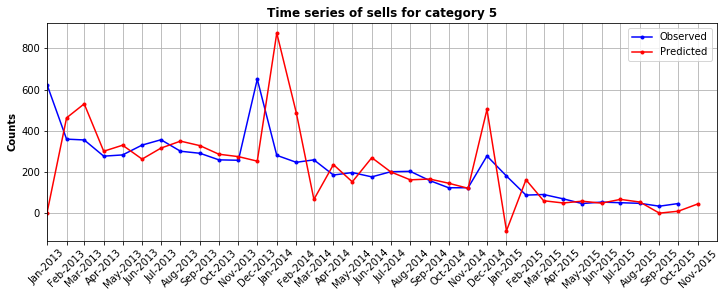

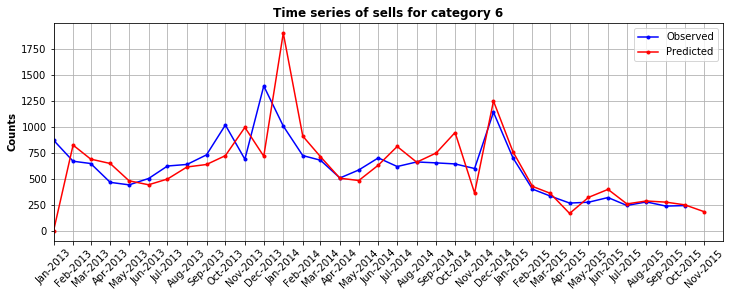

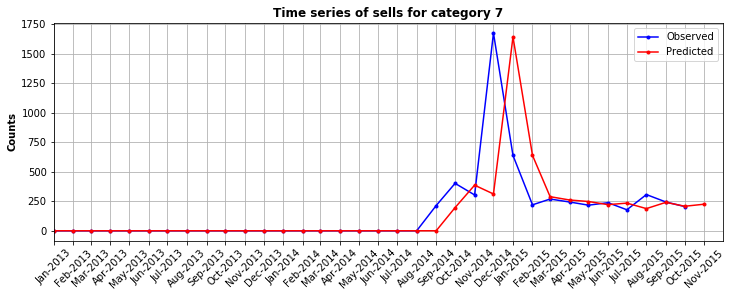

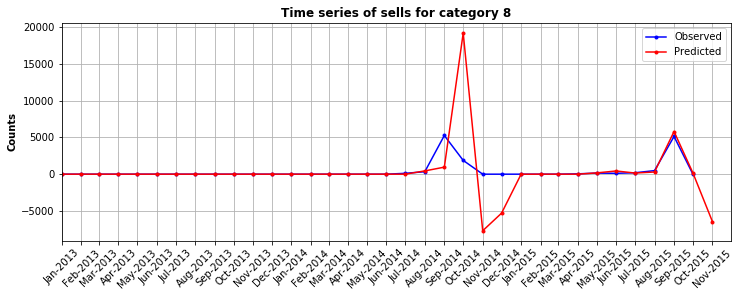

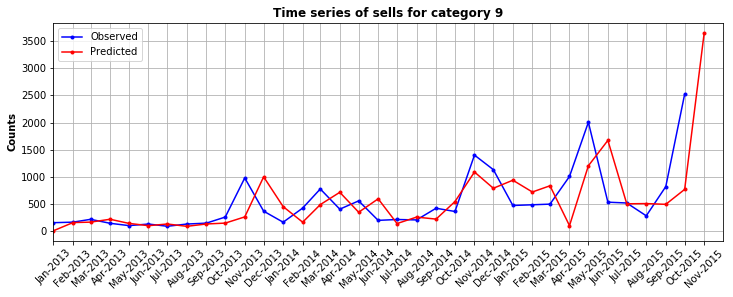

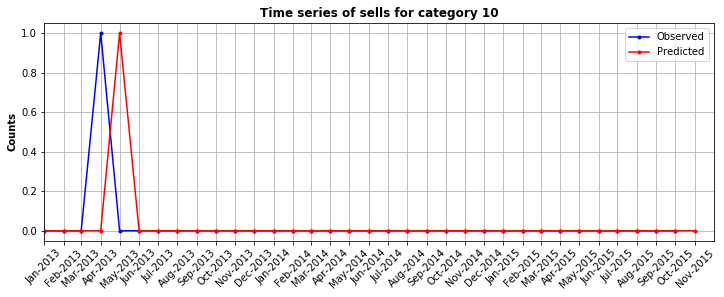

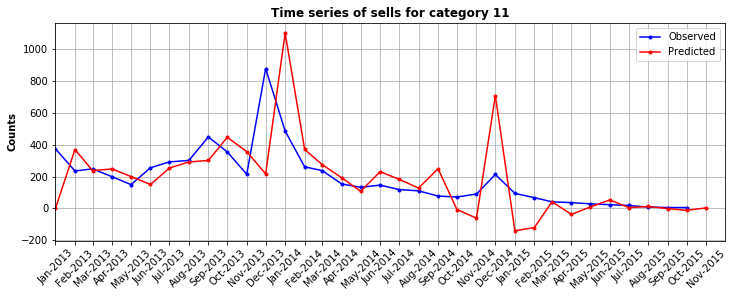

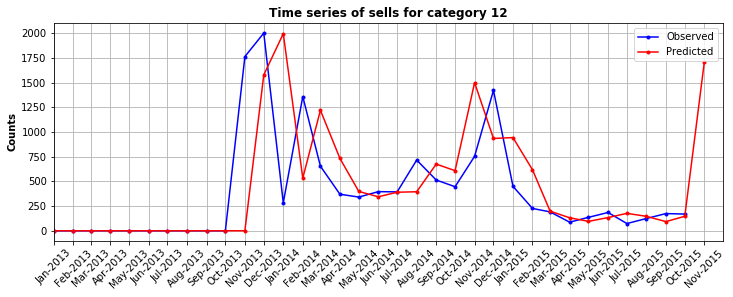

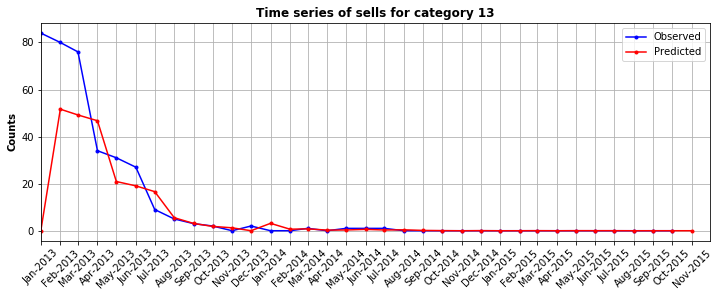

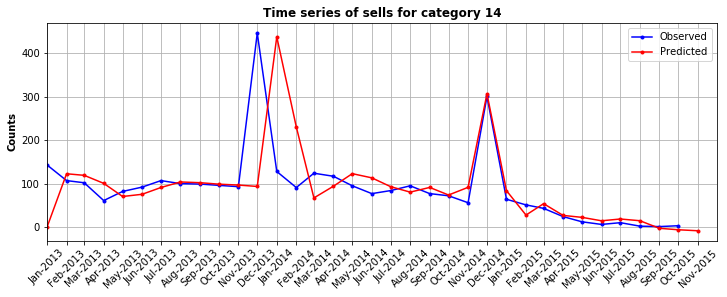

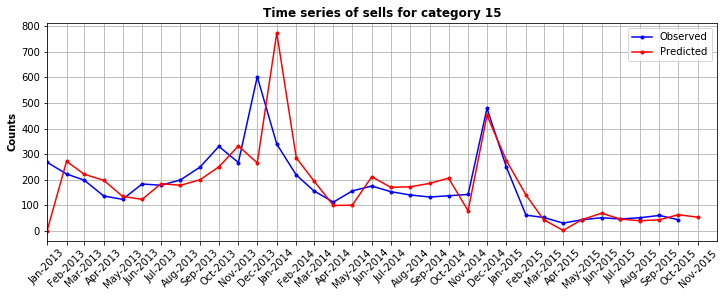

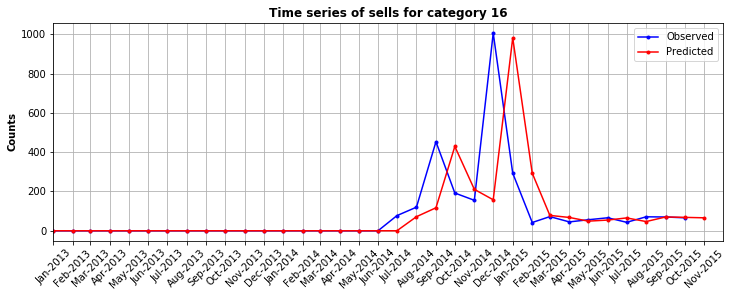

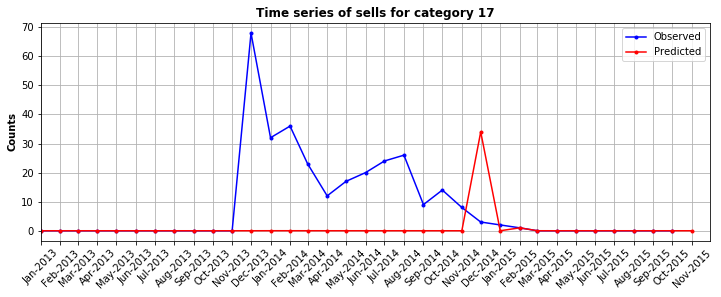

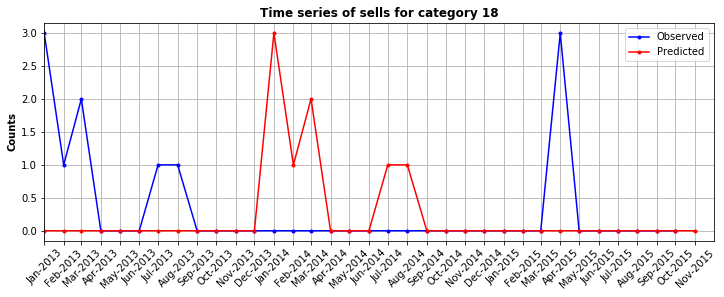

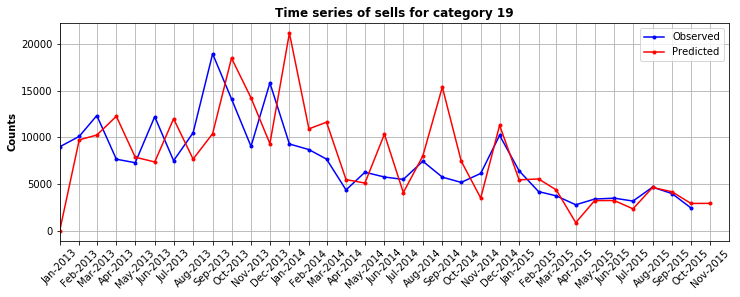

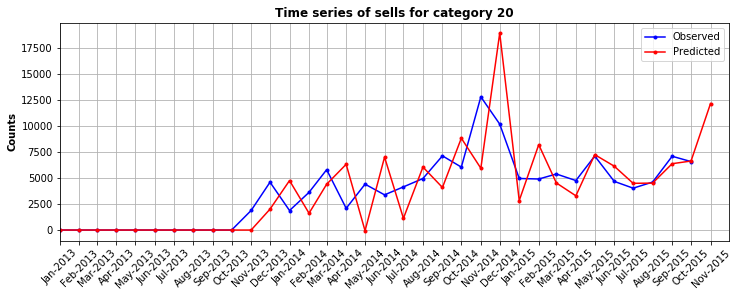

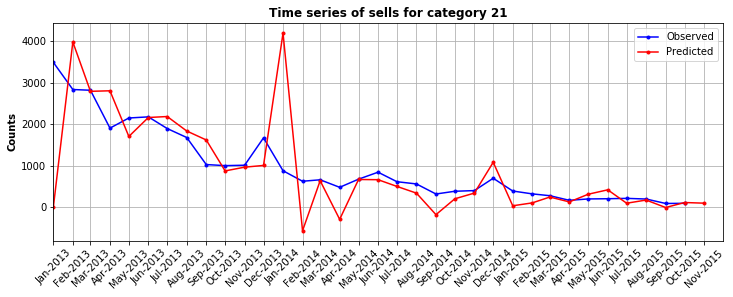

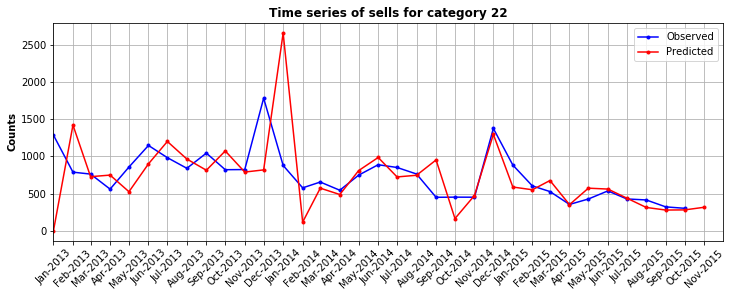

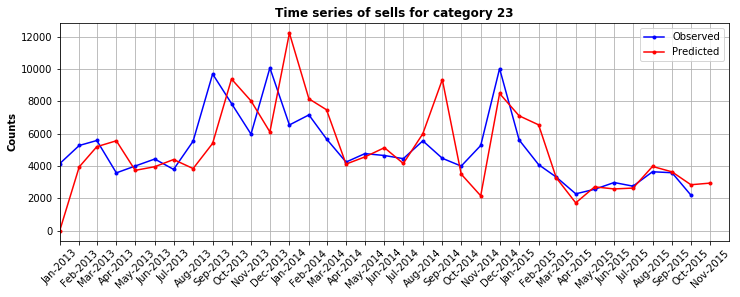

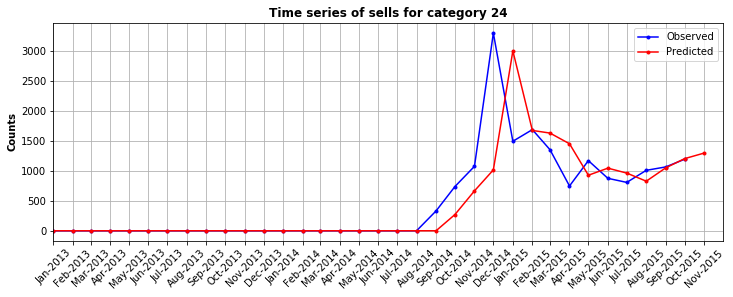

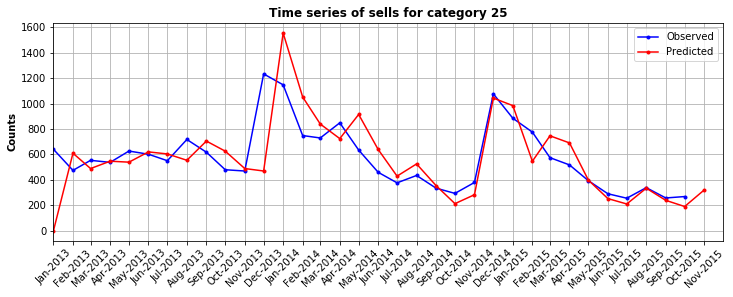

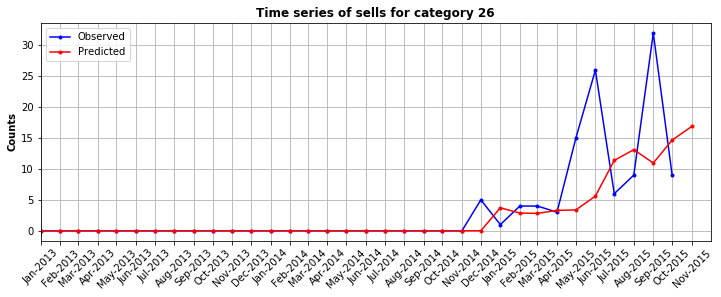

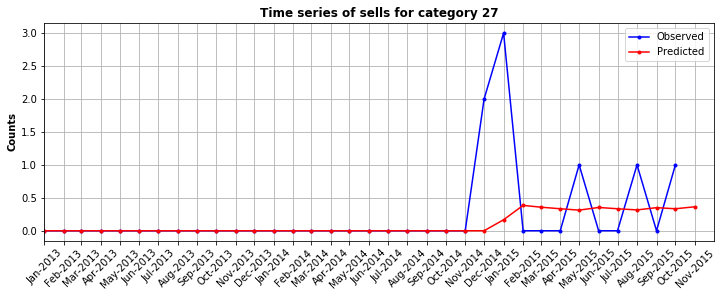

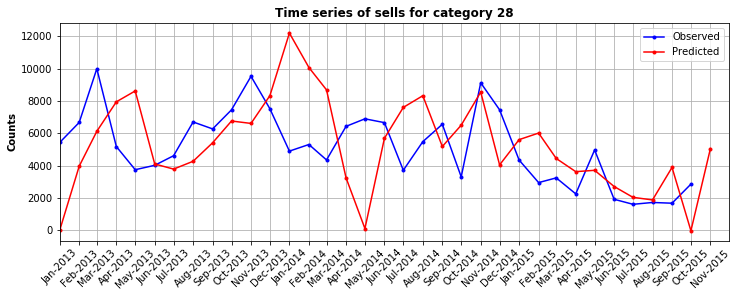

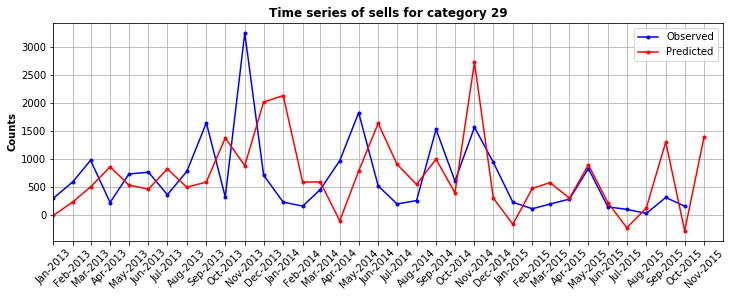

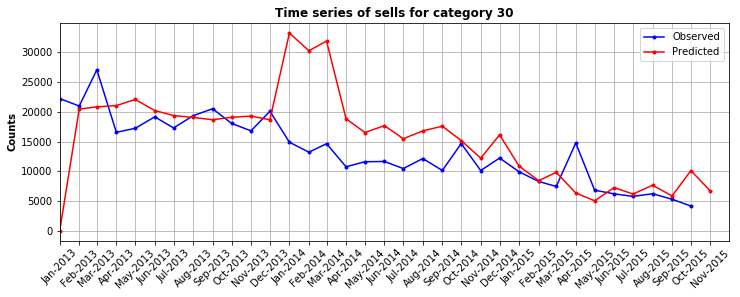

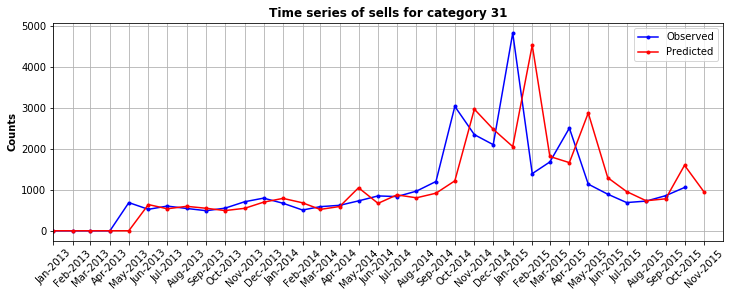

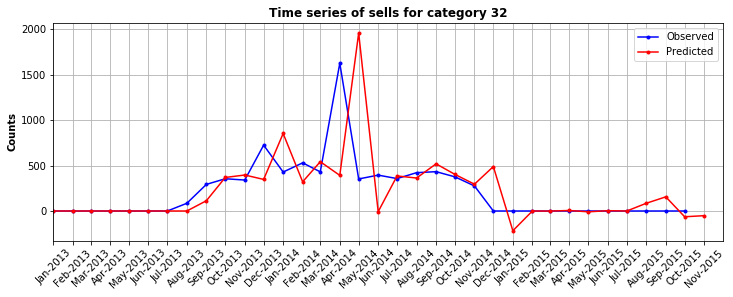

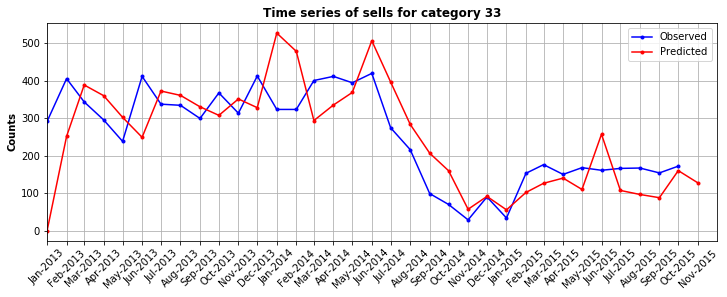

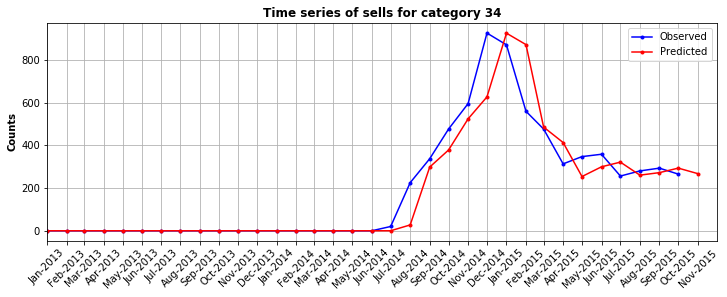

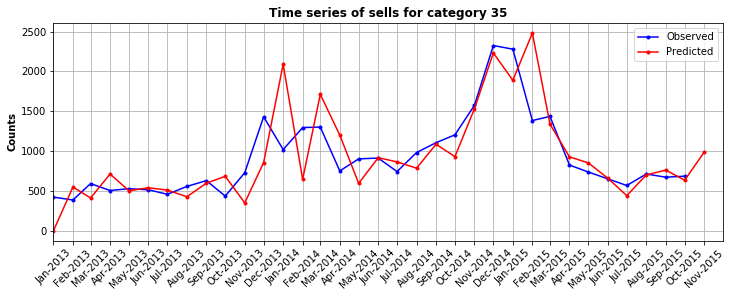

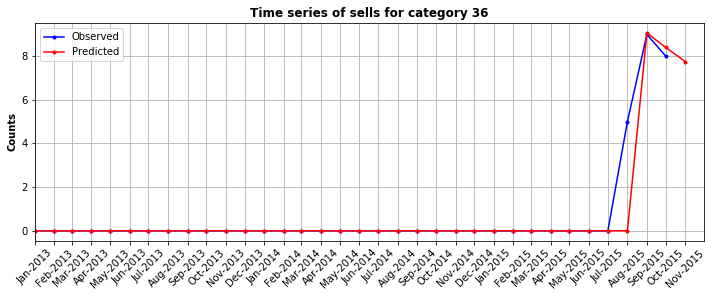

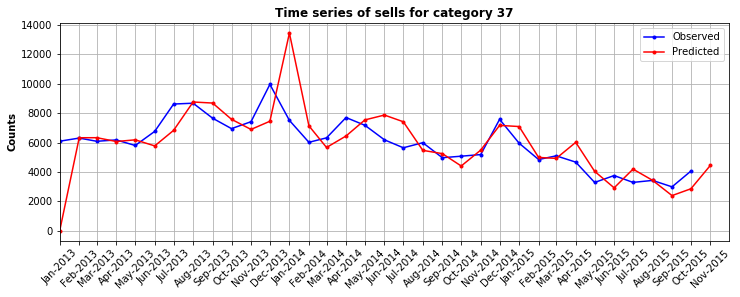

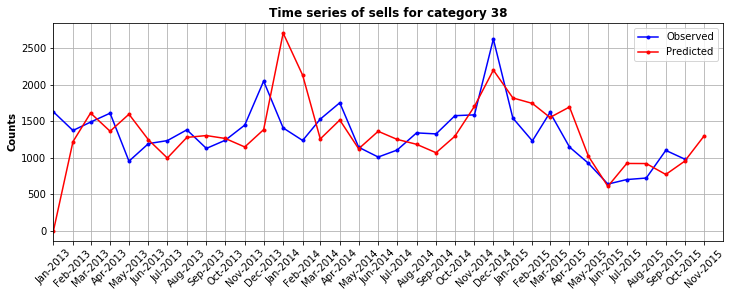

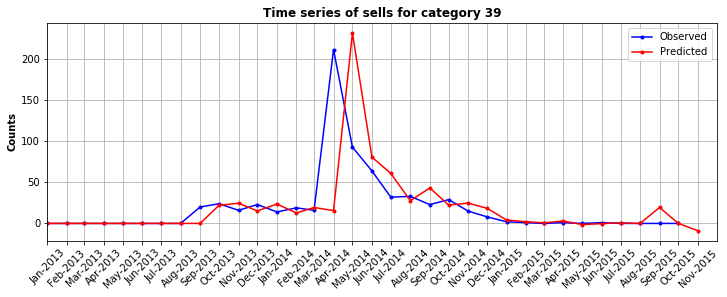

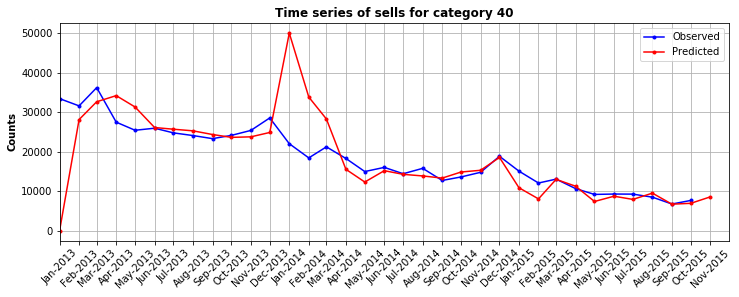

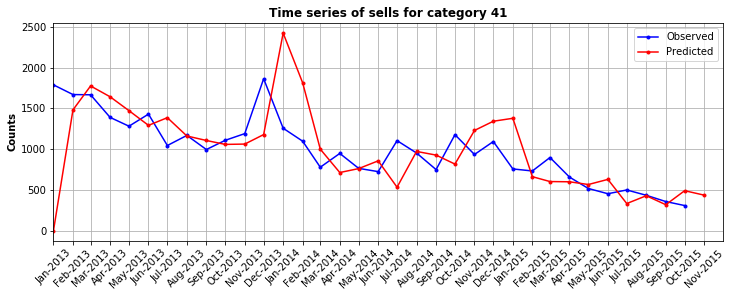

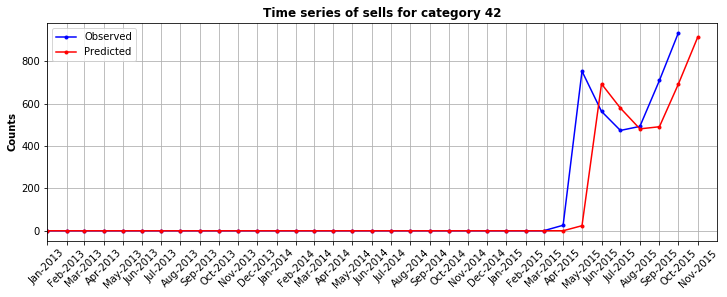

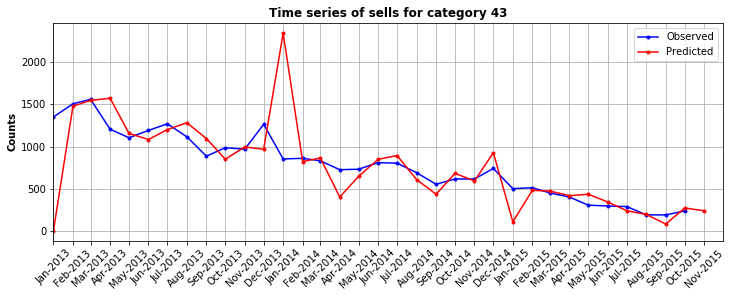

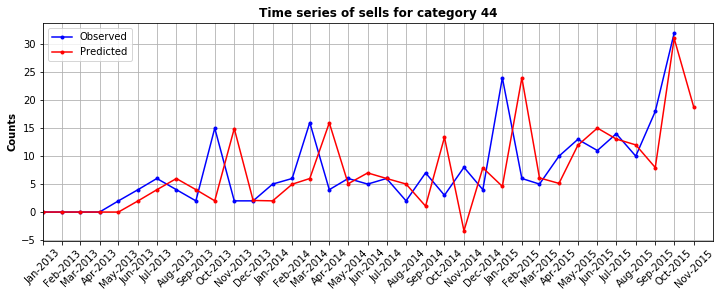

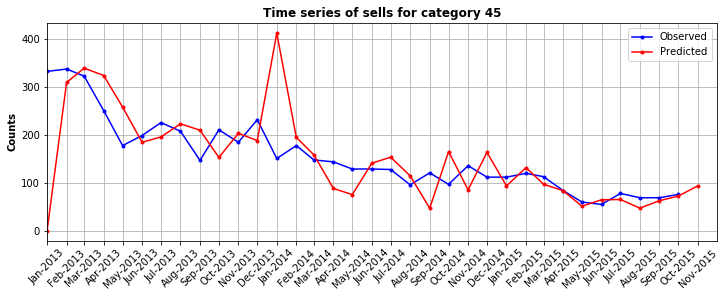

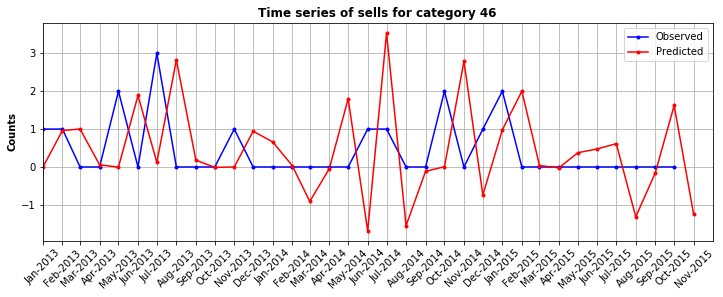

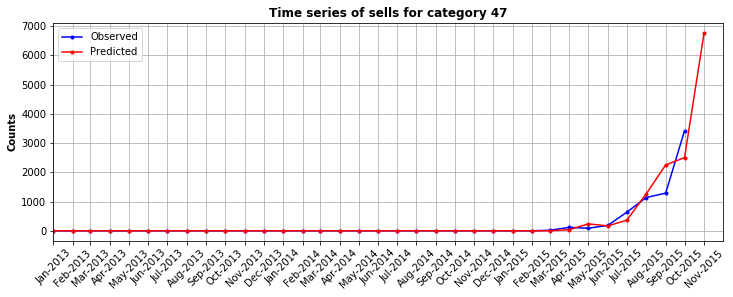

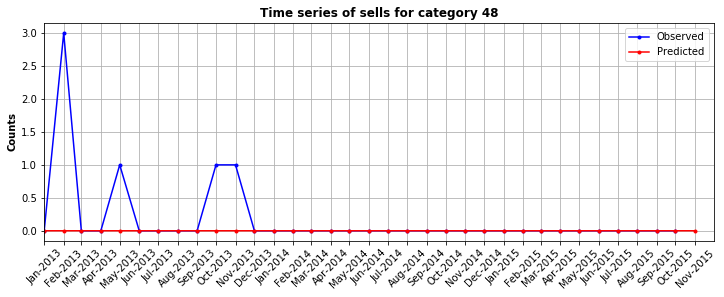

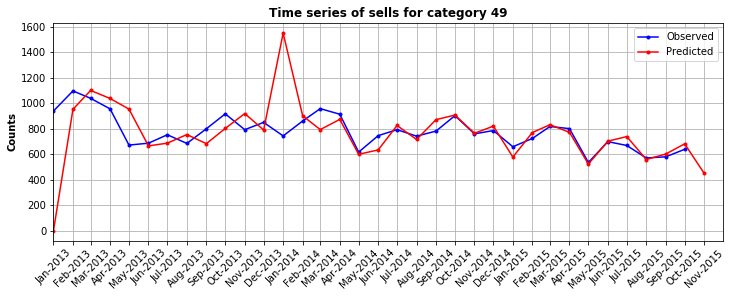

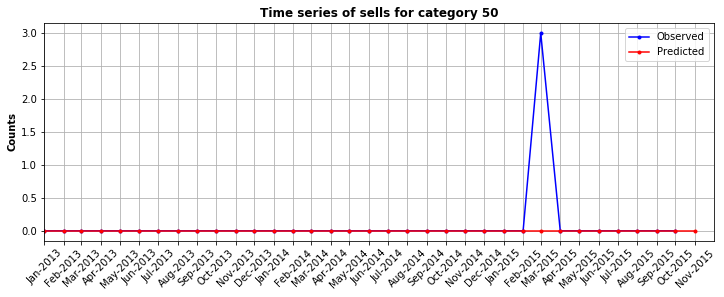

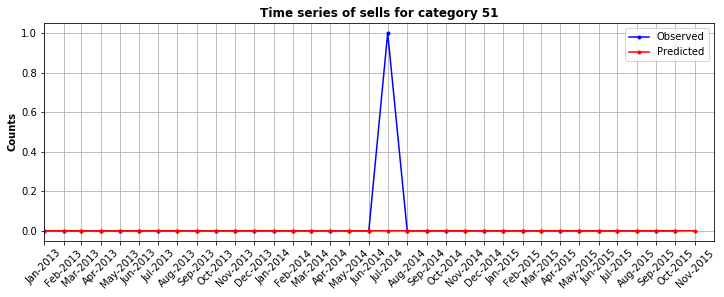

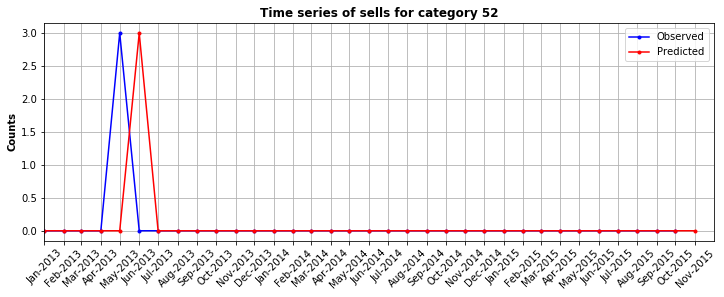

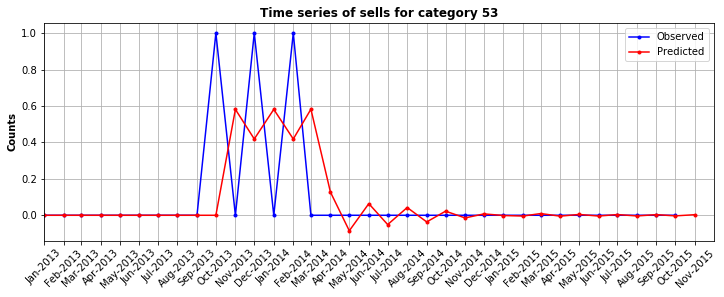

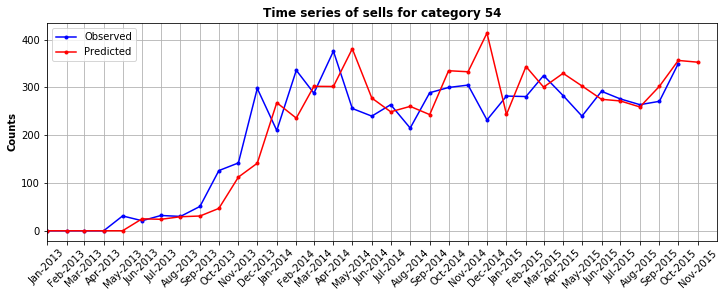

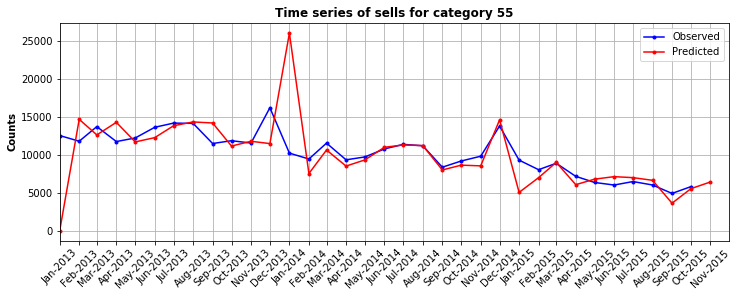

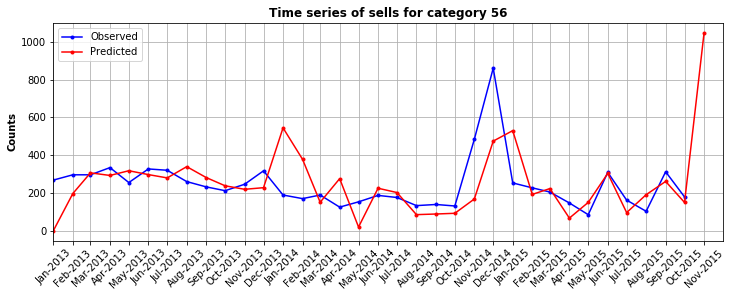

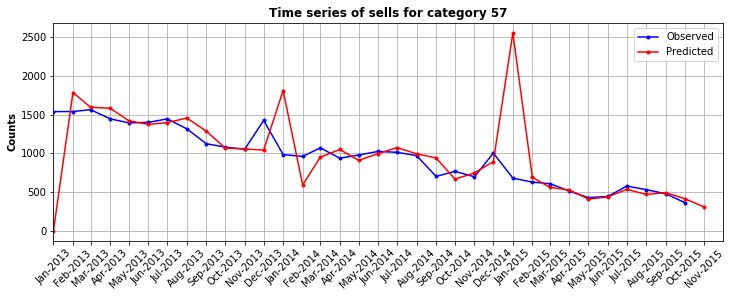

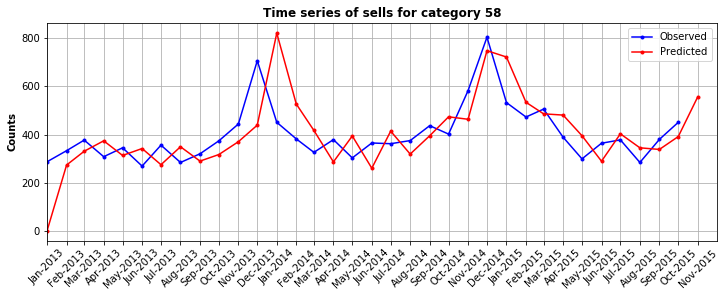

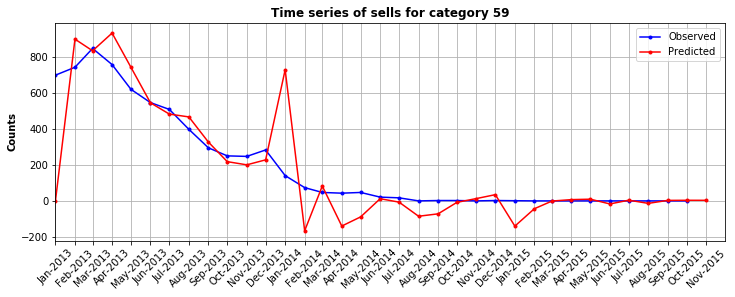

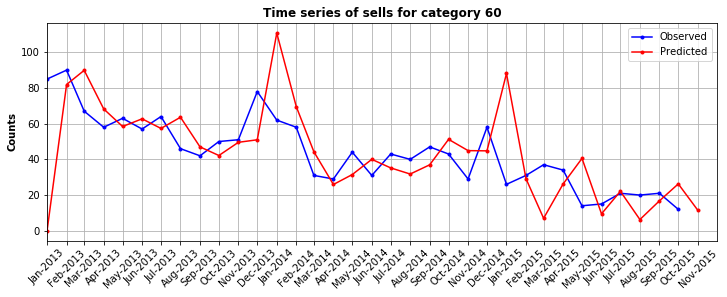

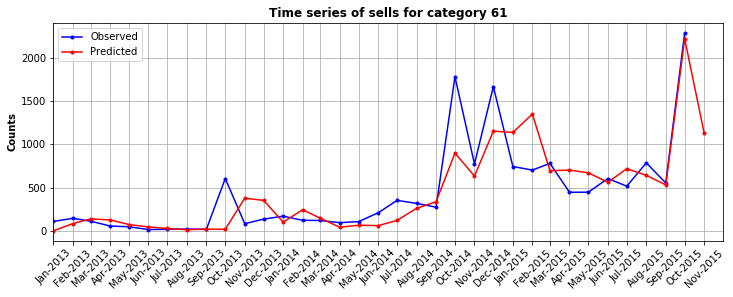

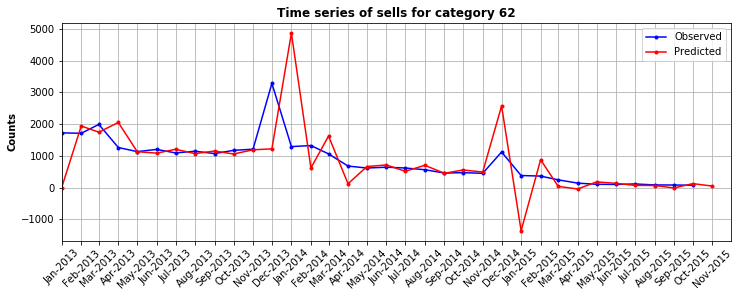

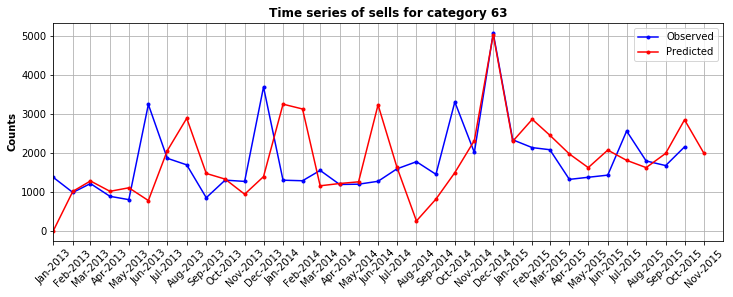

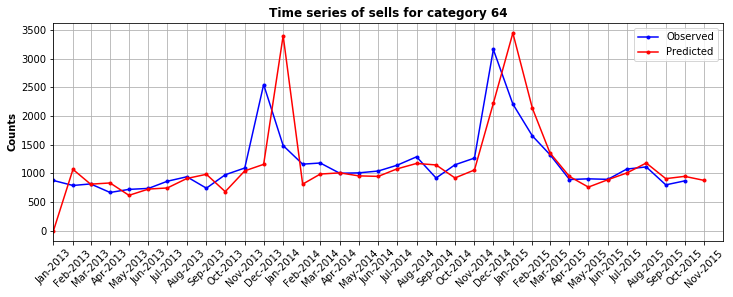

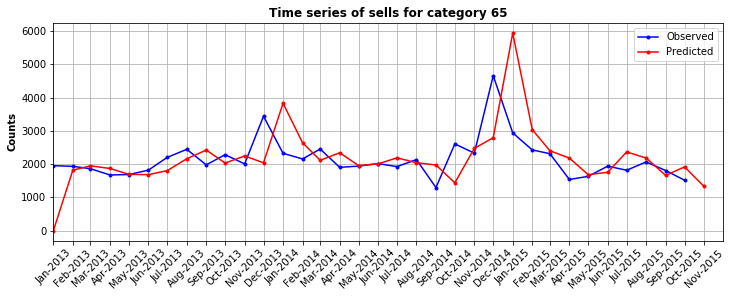

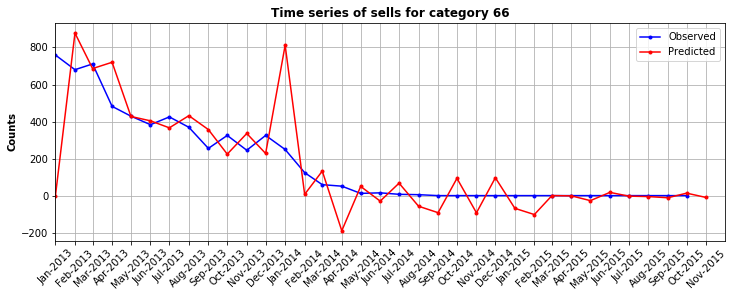

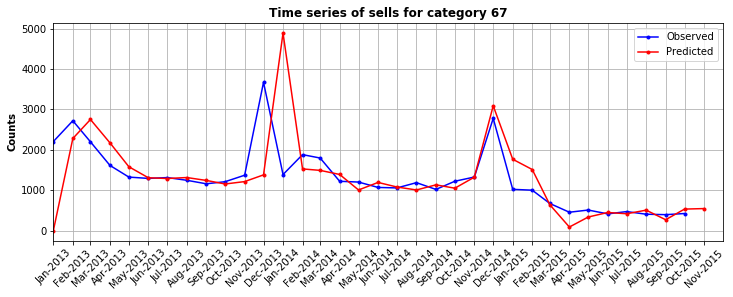

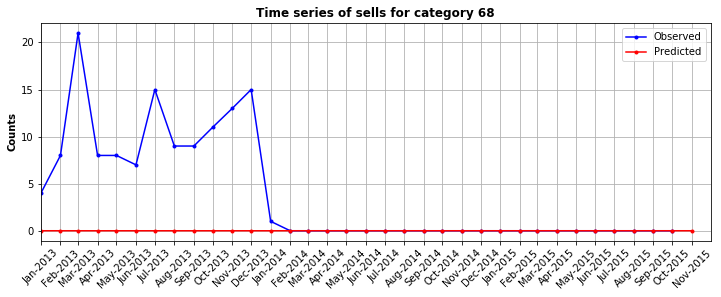

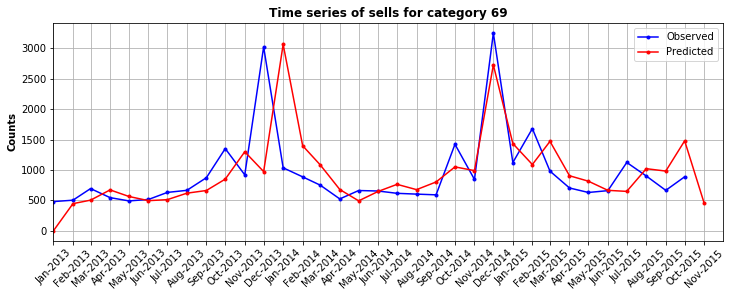

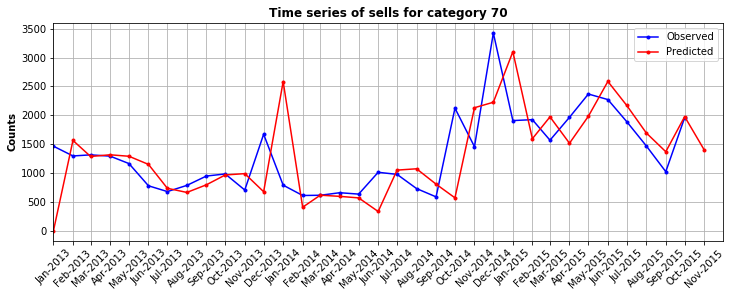

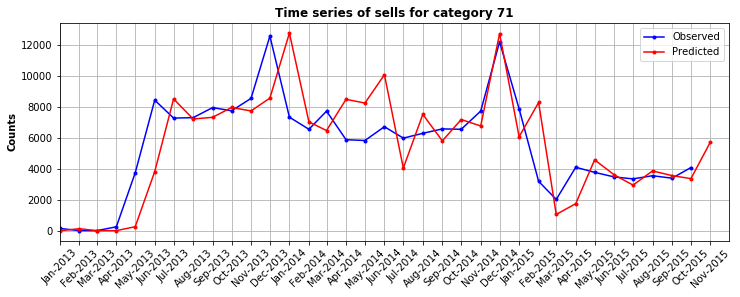

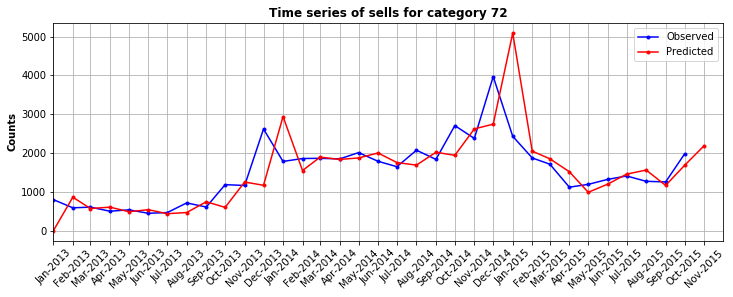

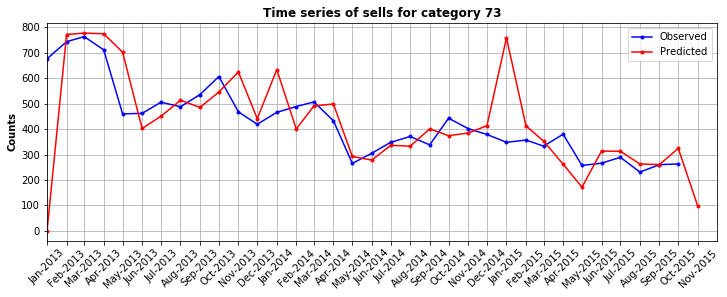

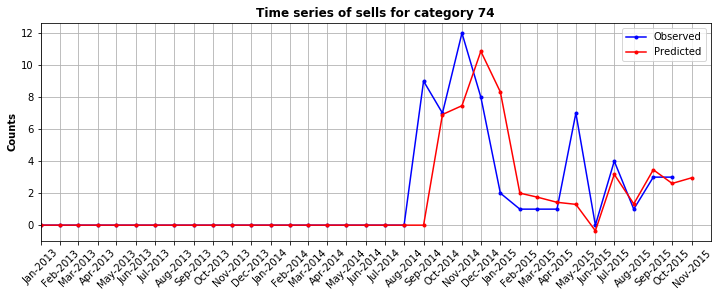

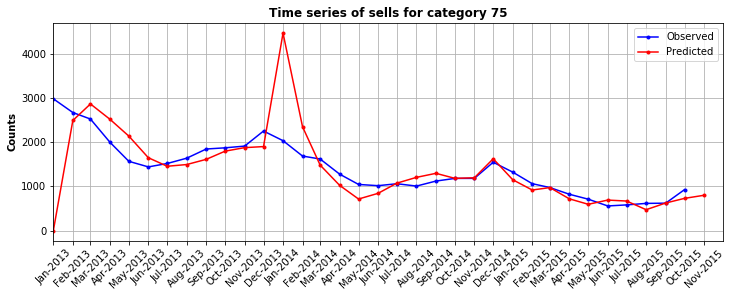

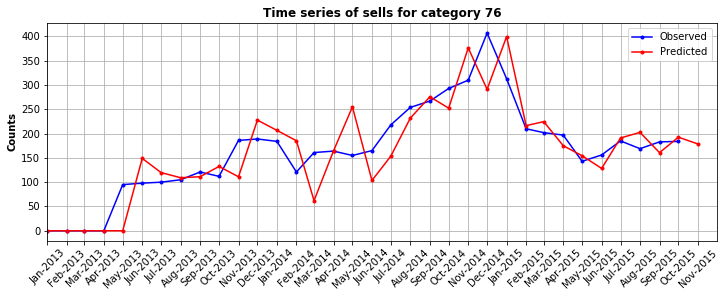

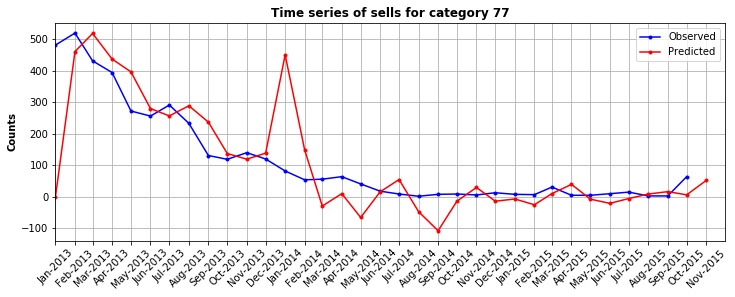

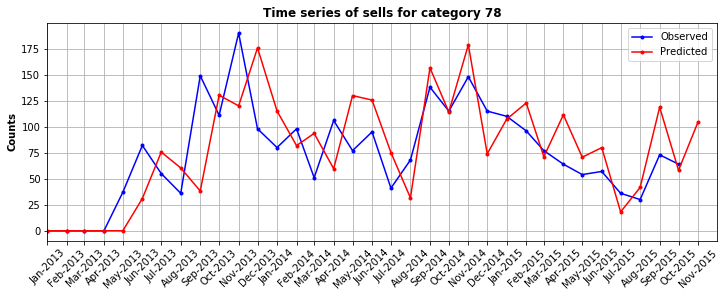

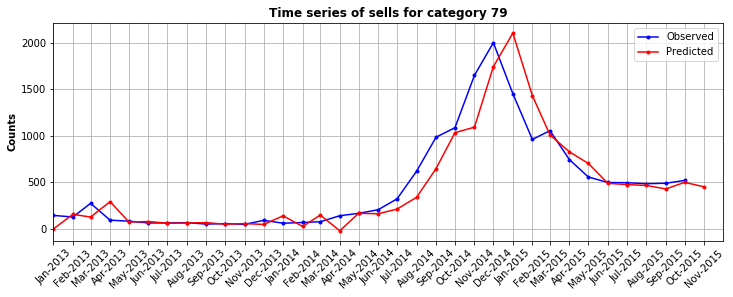

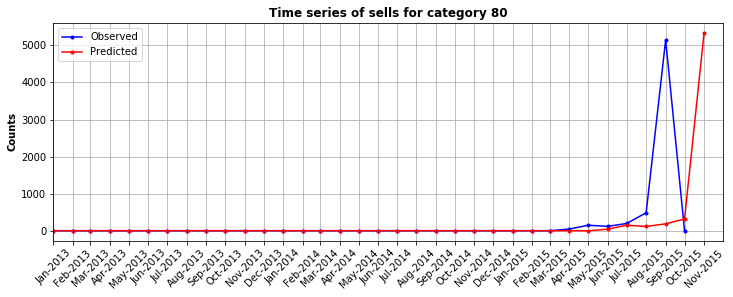

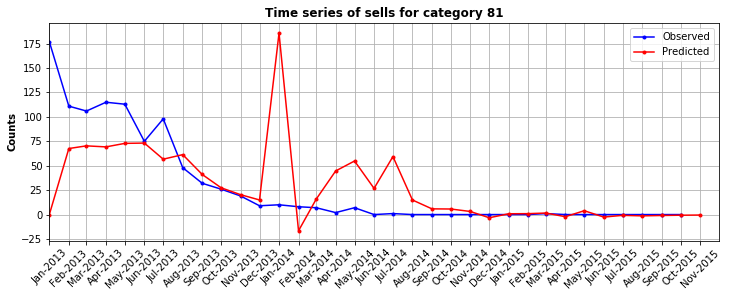

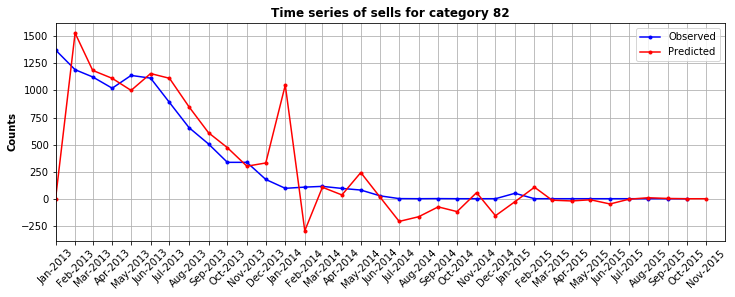

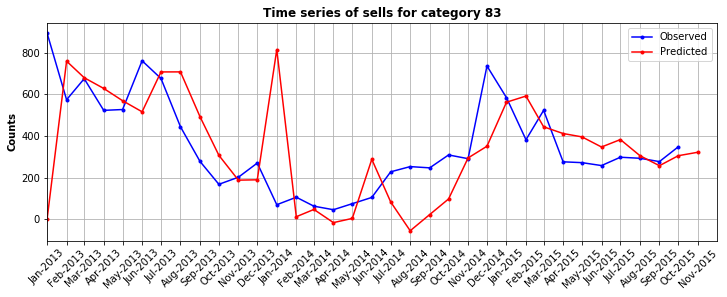

In [34]:
# Loop over the remaining categories.
for cat in range(1, TS.shape[0]):
    ts = TS.iloc[cat, :]
    results = grid_search(ts, pdq, PDQs, verbose=False)

    plots(ts, results, cat)